#Progressive GAN
Progressive growing and smoothing of higher-resolution layers: "Transfer-learning" lower resolution parameters onto higher resolution parameters. 

In [ ]:
import tensorflow as tf
import keras as K

## Progressive growing and smooth upscaling
Start by smoothly merging the parametric upscale with the learned upscale.

In [ ]:
def upscale_layer(layer, upscale_factor):
	'''
	Upscales layer (tensor) by the factor (int) where the tensor is [group, height, width, channels]
	'''
	height, width = layer.get_shape()[1:3]
	size = (upscale_factor * height, upscale_factor * width)
	upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
	return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
	'''
	Smoothly merges in a layer based on a threshold value alpha assuming all layers are in RGB. 
	The parameters:
	list_of_layers	:	items should be tensors ordered by size
	alpha 					: float \in (0,1)
	'''
	last_fully_trained_layer = list_of_layers[-2]
	# The originally trained layer
	last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

	# The newly added not yet fully trained layer 
	larger_native_layer = list_of_layers[-1]

	# Assert that merging code can run
	assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

	new_layer = (1-alpha) * upscaled_layer + larger_native_layer * alpha

	return new_layer

##Minibatch standard deviation
Inform the discriminator about batch sample diversity to avoid mode collapse (when GANs only learn how to create a few good examples or only slight permutations on them).

In [ ]:
def minibatch_std_layer(layer, group_size=4):
  '''
  Will calculate minibatch standard deviation for a layer under a pre-specified tf-scope with Keras.
  Assumes layer is a float32 data type or cast.  
  '''
  # Minibatch group must be divisible by or less than group_size
  group_size = K.backend.minimum(group_size, tf.shape(layer)[0])

  # Shorthand shape information to ensure defaults
  shape = list(K.int_shape(input))
  shape[0] = tf.shape(input)[0]

  # Reshape to minibatch expectation, layers are [Group (G), Minibatch (M), Width (W), Height (H), Channel (C)]
  minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))

  # Center the mean over the group [M, W, H, C]
  minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True) 
  
  # Calculate the variance of the group [M, W, H, C]
  minibatch = tf.reduce_mean(K.backend.square(minibatch), axis = 0)
  
  # Calculate the standard deviation over the group [M, W, H, C]
  minibatch = K.backend.square(minibatch + 1e8) # [4D -> 3D] 
  
  # Take average over feature maps and pixels [M, 1, 1, 1]
  minibatch = tf.reduce_mean(minibatch, axis=[1,2,4], keepdims=True) # [3D -> 2D]
  
  # Add as a layer for each group and pixels
  minibatch = K.backend.tile(minibatch, [group_size, 1, shape[2], shape[3]]) # [2D -> Scalar/0D] 
  
  # Append as a new feature map
  return K.backend.concatenate([layer, minibatch], axis=1)

##Equalized Learning Rate 
"A hack that seems to work"


In [ ]:
def equalize_learning_rate(shape, gain, fan_in=None):
    '''
    Adjusts layer weights by the constant from He initialization to modify for variance 
    in different features' dynamic range. 
    shape   :   shape of tensor (layer): these are the dimensions of each layer.
                For example, [4,4,48,3]. In this case, [kernel_size, kernel_size, number_of_filters, feature_maps]. 
                Depend slightly on implementation.
    gain    :   typically sqrt(2)
    fan_in  :   adjustment for the number of incoming connections as per Xavier/He initialization 
    '''
    # Default value is product of shape dim minus feature maps dim. Provides number of incoming connections per neuron
    if fan_in is None: fan_in = np.prod(shape[:-1])
    
    # Uses He initialization constant
    std = gain / K.sqrt(fan_in)
    
    # Creates a constant from adjustment
    wscale = K.constant(std, name='wscale', dtype=np.float32)
    
    # Gets weight valuesand broadcasts to apply the adjustment
    adjusted_weights = K.get_value('layer', shape=shape, initializer=tf.initializers.random_normal()) * wscale

    return adjusted_weights

##Pixel-wise Feature Normalization
Prevents explosion in feature magnitudes during divergent training. In order for batch normalization to work, mini-batches must be large so individual samples average out, but batch
normalization is too memory intensive at this resolution and will not work, given megapixel resolution.

In [ ]:
def pixelwise_feat_norm(inputs, **kwargs):
	'''
	Pixelwise feature normalization (returns the input normalized).
	:inputs 	: 	Keras / TF Layers 
	'''
	normalization_constant = K.backend.sqrt(K.backend.mean(inputs**2, axis=-1, keepdims=True) + 1.0e-8)
 
	return inputs / normalization_constant

##Run the PGGAN with TensorFlow Hub (no training required)

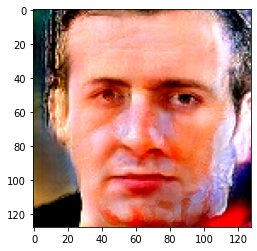

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

with tf.Graph().as_default():
    # import the progressive GAN from TFHub
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    # latent dimension that gets sampled at runtime
    latent_dim = 512

    # Random seed to get different faces
    latent_vector = tf.random.normal([1, latent_dim], seed=1337)

    # Use TFHub module to generate images from the latent space
    interpolated_images = module(latent_vector)

    # Run tensorflow session and get back image in shape (1,128,128,3)
    tf.compat.v1.disable_eager_execution() # added
    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())  
      image_out = session.run(interpolated_images)

plt.imshow(image_out.reshape(128,128,3))
plt.show()

#Extend the PGGAN
##TF-Hub generative image model

TF-Hub module based on a GAN. The module maps from N-dimensional vectors (latent space) to RGB images. First a mapping from latent space to images and, given a target image, gradient descent to find a latent vector that generates an image similar to the target image.

In [ ]:
# Install TF-Hub.
#!pip install tensorflow-hub
# Install imageio for creating animations.  
#!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# added
"""
!tf_upgrade_v2 \
  --intree my_project/ \
  --outtree my_project_v2/ \
  --reportfile report.txt
"""  

TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 0 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform
import logging #added

# Retrieve value from module.get_input_shapes() if TFHub module unknown
latent_dim = 512

# Interpolate between two non-zero vectors that don't both lie on a line going through the origin
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm) # normalize v2 to have the same norm as v1

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized) # interpolate between the two vectors on the hypersphere
  return tf.stack(vectors)


# Given a set of images, show an animation
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))

# Display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)

# Display multiple images in same figure
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

tf.compat.v1.logging.set_verbosity(logging.ERROR)  

##Latent space interpolation
###Random vectors
Latent space interpolation between two randomly initialized vectors. Use a TF-Hub module progan-128 that contains a pre-trained Progressive GAN.

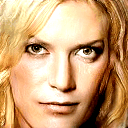

In [ ]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    #  Random seed to get different vectors
    v1 = tf.random.normal([latent_dim], seed=3)
    v2 = tf.random.normal([latent_dim], seed=1)
    
    # Create a tensor with 50 steps of interpolation between v1 and v2
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Use TFHub module to generate images from latent space
    interpolated_images = module(vectors)

    tf.compat.v1.disable_eager_execution() # added
    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())  
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

##Find closest vector in latent space
Fix a target image generated from the module.

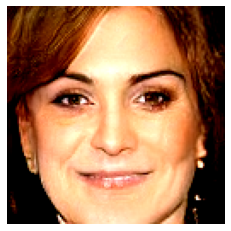

In [ ]:
image_from_module_space = True  

def get_module_space_image():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random.normal([1, latent_dim], seed=4)
    images = module(vector)

    tf.compat.v1.disable_eager_execution() # added
    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())  
      image_out = session.run(images)[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[uploaded.keys()[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

##Gradient descent to find a latent
After defining a loss function between the target image and the image generated by a latent space variable, use gradient descent to find variable values that minimize the loss.

In [ ]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random.normal([1, latent_dim], seed=5)

    vector = tf.compat.v1.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        tf.compat.v1.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to 
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
    
    loss = target_image_difference + regularizer
    
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    tf.compat.v1.disable_eager_execution() # added
    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())
      for _ in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        print(loss_out)
    return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)

0.688769
5.607328
5.049136
2.72568
0.731543
1.4969783
0.8284998
1.1469496
1.4737451
0.7809746
0.87810314
1.2610589
0.8297903
0.51265454
0.76557225
0.28102878
1.0129623
1.3110301
0.95786905
0.17551482
0.3888396
0.22738981
0.20052832
0.38011557
0.14696506
0.82903665
0.95325136
0.4999729
0.6412761
0.94277304
0.6888937
0.25466222
0.40383554
0.17239866
0.18595296
0.35645202
0.16533995
0.6991084
0.79808414
0.37114802


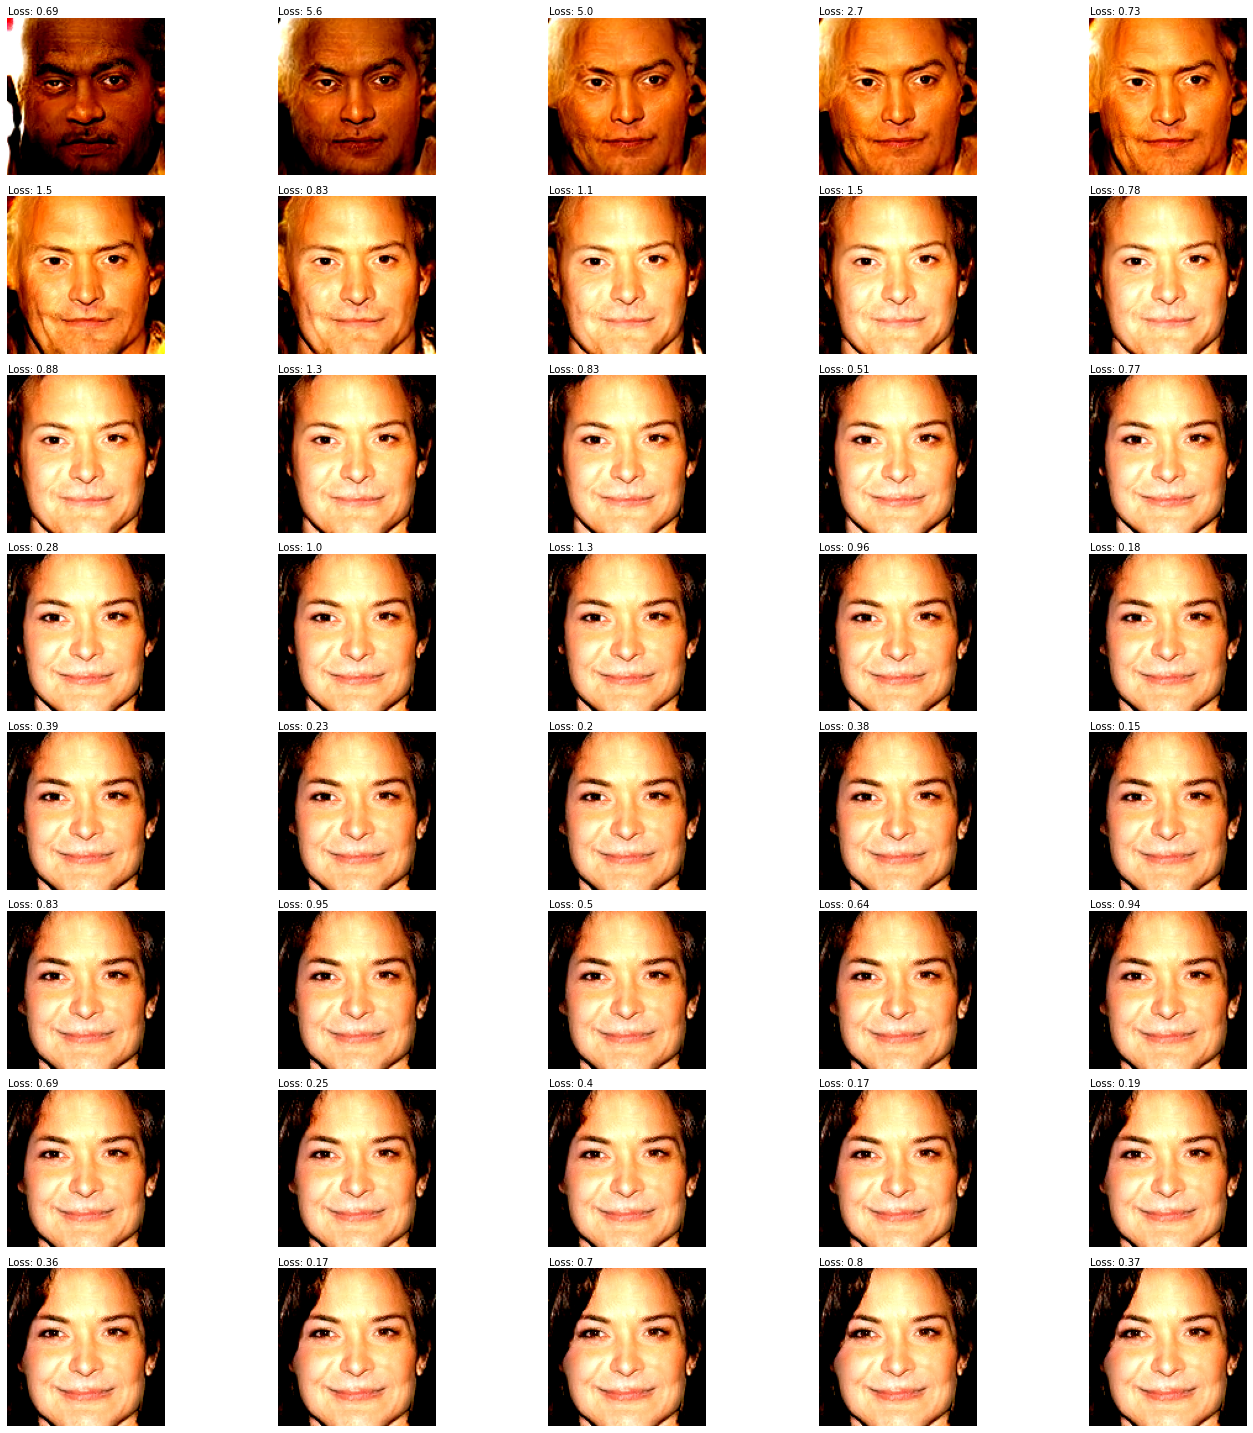

In [ ]:
captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)

# References
Codes from the book *GANs in Action* by Jakub Langr and Vladimir Bok, and from TensorFlow.org.